# Load modules and dataset

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, make_scorer, precision_score, recall_score, log_loss
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import MobileBertTokenizer, TFMobileBertModel
from transformers import AutoTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate, Bidirectional
from sklearn.model_selection import StratifiedKFold, cross_validate
import torch
import requests
from tensorflow.keras import activations, optimizers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/PHEME/data.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df.head()

,text,target
0,"AFP reports there are 2 dead, and 5 hostages b...",unverified
1,#BREAKING Hostages taken north-east of Paris: ...,false
2,#ChalieHebdo terrorists are held up in a wareh...,false
3,"Top French cartoonists Charb, Cabu, Wolinski, ...",unverified
4,URGENT: Both #CharlieHebdo suspects killed - r...,true


In [ ]:
label_encoder = LabelEncoder()
label = df['target']
labels_encoded = label_encoder.fit_transform(label)
df['target'] = labels_encoded
df.head()

,text,target
0,"AFP reports there are 2 dead, and 5 hostages b...",2
1,#BREAKING Hostages taken north-east of Paris: ...,0
2,#ChalieHebdo terrorists are held up in a wareh...,0
3,"Top French cartoonists Charb, Cabu, Wolinski, ...",2
4,URGENT: Both #CharlieHebdo suspects killed - r...,1


# Fine Tune DistilBERT

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=3,output_hidden_states=True)

for layer in model_distil.layers:
    layer.trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokenizer_distil(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(df['text'].tolist(), tokenizer_distil, max_len=512)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, df['target'].tolist())

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(df['text'].tolist()) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(df['text'].tolist()))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
N_EPOCHS = 3
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/3
961/961 [==============================] - 93s 53ms/step - loss: 0.7123 - accuracy: 0.7033
Epoch 2/3
961/961 [==============================] - 42s 44ms/step - loss: 0.4675 - accuracy: 0.8246
Epoch 3/3
961/961 [==============================] - 40s 42ms/step - loss: 0.2992 - accuracy: 0.8964


In [ ]:
benchmarks = model_distil.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)

241/241 [==============================] - 6s 18ms/step - loss: 0.2124 - accuracy: 0.9272


In [ ]:
print(benchmarks)

{'loss': 0.212358757853508, 'accuracy': 0.927234947681427}


In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


# Create Embeddings

In [ ]:
import nltk
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['text'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 2402/2402 [04:20<00:00,  9.22it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['target'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/PHEME/embeddings.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/PHEME/labels.npy', labels)

# Statements - Titles

## **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/PHEME/embeddings.npy')
labels = np.load('/content/drive/MyDrive/PHEME/labels.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([1921, 768, 1])

In [ ]:
train_labels.shape

(1921,)

In [ ]:
train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

In [ ]:
train_labels.shape

(1921, 3)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
121/121 [==============================] - 13s 9ms/step - loss: 0.8316 - accuracy: 0.5799
Epoch 2/10
121/121 [==============================] - 1s 7ms/step - loss: 0.2374 - accuracy: 0.9344
Epoch 3/10
121/121 [==============================] - 1s 7ms/step - loss: 0.2091 - accuracy: 0.9495
Epoch 4/10
121/121 [==============================] - 1s 7ms/step - loss: 0.1778 - accuracy: 0.9500
Epoch 5/10
121/121 [==============================] - 1s 6ms/step - loss: 0.1756 - accuracy: 0.9490
Epoch 6/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1559 - accuracy: 0.9558
Epoch 7/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1366 - accuracy: 0.9578
Epoch 8/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1349 - accuracy: 0.9599
Epoch 9/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1235 - accuracy: 0.9625
Epoch 10/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1019 - accuracy: 0.968

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 0s 3ms/step
Test Accuracy: 0.9355509281158447
Test F1 Score: 0.936863676416421
Test Recall: 0.9311994602239405
Precision: 0.9447144075021313


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0

16/16 [==============================] - 0s 4ms/step
[[113   3   2]
 [  1 203  10]
 [  3   4 142]]


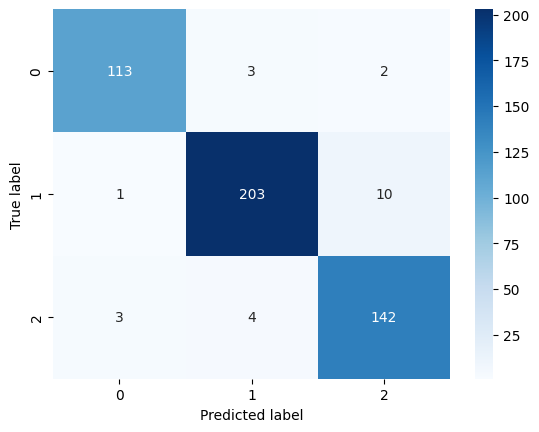

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):

    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    print(classification_report(a, y_pred))

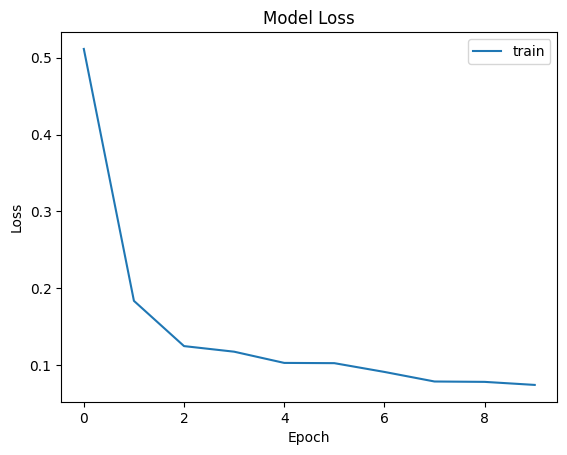

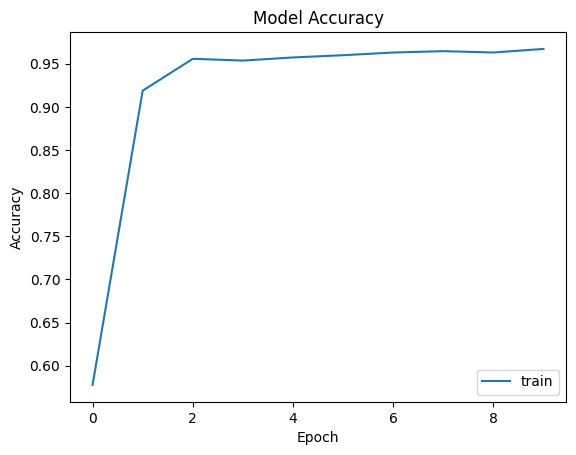

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       118
           1       0.97      0.95      0.96       214
           2       0.92      0.95      0.94       149

    accuracy                           0.95       481
   macro avg       0.95      0.95      0.95       481
weighted avg       0.95      0.95      0.95       481



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
96/96 [==============================] - 3s 5ms/step - loss: 0.5997 - accuracy: 0.4544
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 0.2294 - accuracy: 0.8939
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.1298 - accuracy: 0.9447
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 0.1134 - accuracy: 0.9538
Epoch 5/10
96/96 [==============================] - 0s 4ms/step - loss: 0.1053 - accuracy: 0.9544
Epoch 6/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9635
Epoch 7/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0883 - accuracy: 0.9590
Epoch 8/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0862 - accuracy: 0.9596
Epoch 9/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.9688
Epoch 10/10
13/13 [==============================] - 0s 3ms/step - loss: 0.1060 - accuracy: 0.9558
Epoch 1/10
97/97 [=

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9552313311688311
Precision: 0.955620651485912
Loss: 0.10393378138542175
Recall: 0.9552313311688311
F1-score: 0.9551943823705269


## **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
121/121 [==============================] - 10s 22ms/step - loss: 0.1494 - accuracy: 0.9271 - val_loss: 0.5055 - val_accuracy: 0.9106
Epoch 2/10
121/121 [==============================] - 2s 13ms/step - loss: 0.0958 - accuracy: 0.9552 - val_loss: 0.4327 - val_accuracy: 0.9439
Epoch 3/10
121/121 [==============================] - 2s 13ms/step - loss: 0.0816 - accuracy: 0.9547 - val_loss: 0.3283 - val_accuracy: 0.9314
Epoch 4/10
121/121 [==============================] - 2s 13ms/step - loss: 0.0674 - accuracy: 0.9677 - val_loss: 0.1551 - val_accuracy: 0.9376
Epoch 5/10
121/121 [==============================] - 2s 13ms/step - loss: 0.0579 - accuracy: 0.9698 - val_loss: 0.1324 - val_accuracy: 0.9314
Epoch 6/10
121/121 [==============================] - 2s 14ms/step - loss: 0.0479 - accuracy: 0.9771 - val_loss: 0.1271 - val_accuracy: 0.9418
Epoch 7/10
121/121 [==============================] - 2s 16ms/step - loss: 0.0449 - accuracy: 0.9771 - val_loss: 0.2304 - val_accuracy: 0.877

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 1s 6ms/step
Test Accuracy: 0.9126819372177124
Test F1 Score: 0.9108008303931658
Test Recall: 0.9096390708282437
Precision: 0.9197719918863255


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 189, 64)           49408     
                                                                 
 batch_normalization (BatchN  (None, 189, 64)         

16/16 [==============================] - 0s 6ms/step
[[101   3  14]
 [  1 194  19]
 [  1   4 144]]


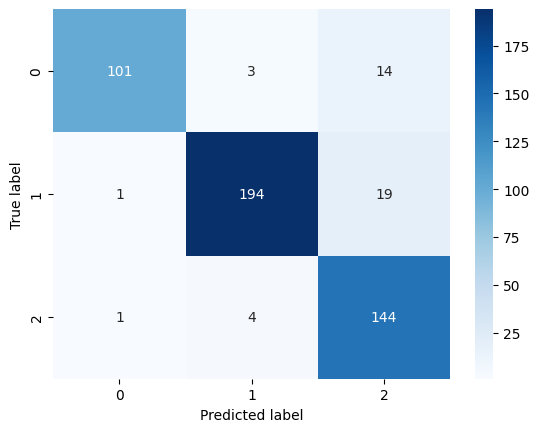

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

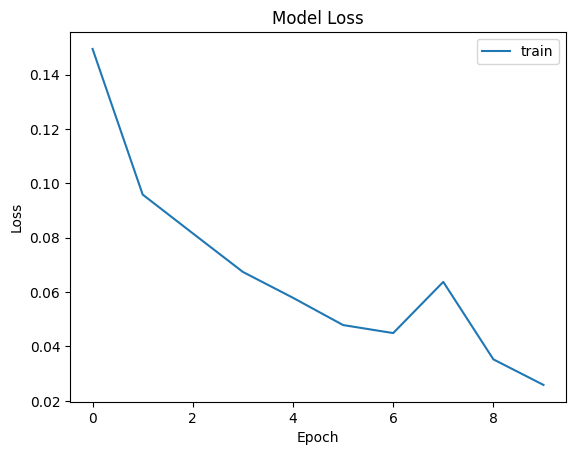

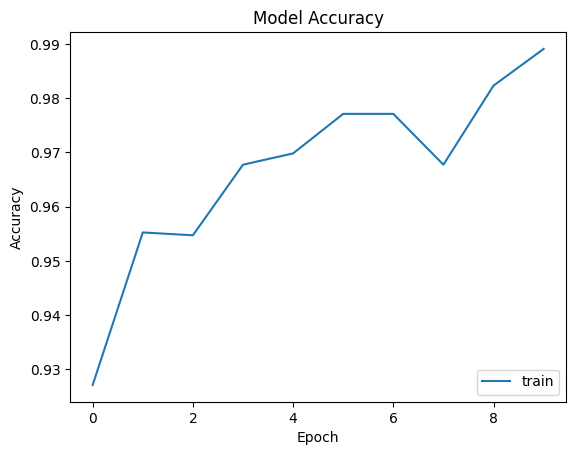

              precision    recall  f1-score   support

           0       0.98      0.86      0.91       118
           1       0.97      0.91      0.93       214
           2       0.81      0.97      0.88       149

    accuracy                           0.91       481
   macro avg       0.92      0.91      0.91       481
weighted avg       0.92      0.91      0.91       481



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(3, activation='softmax'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)


    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
96/96 [==============================] - 5s 11ms/step - loss: 0.1648 - accuracy: 0.9089
Epoch 2/10
96/96 [==============================] - 1s 10ms/step - loss: 0.1053 - accuracy: 0.9414
Epoch 3/10
96/96 [==============================] - 1s 13ms/step - loss: 0.0818 - accuracy: 0.9564
Epoch 4/10
96/96 [==============================] - 1s 13ms/step - loss: 0.0713 - accuracy: 0.9655
Epoch 5/10
96/96 [==============================] - 1s 14ms/step - loss: 0.0596 - accuracy: 0.9688
Epoch 6/10
96/96 [==============================] - 1s 12ms/step - loss: 0.0498 - accuracy: 0.9759
Epoch 7/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0403 - accuracy: 0.9831
Epoch 8/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0298 - accuracy: 0.9863
Epoch 9/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0256 - accuracy: 0.9870
Epoch 10/10
13/13 [==============================] - 1s 8ms/step - loss: 0.1239 - accuracy: 0.9636
Epoch 1/10

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.954185606060606
Precision: 0.955136763000905
Loss: 0.12823541462421417
Recall: 0.954185606060606
F1-score: 0.9540190559399921


## **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(3, activation='softmax')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
121/121 [==============================] - 6s 15ms/step - loss: 0.2106 - accuracy: 0.8886 - val_loss: 0.1411 - val_accuracy: 0.9439
Epoch 2/10
121/121 [==============================] - 1s 12ms/step - loss: 0.1277 - accuracy: 0.9547 - val_loss: 0.1615 - val_accuracy: 0.9418
Epoch 3/10
121/121 [==============================] - 1s 11ms/step - loss: 0.1062 - accuracy: 0.9495 - val_loss: 0.1274 - val_accuracy: 0.9376
Epoch 4/10
121/121 [==============================] - 1s 12ms/step - loss: 0.0918 - accuracy: 0.9563 - val_loss: 0.1106 - val_accuracy: 0.9459
Epoch 5/10
121/121 [==============================] - 1s 12ms/step - loss: 0.0845 - accuracy: 0.9578 - val_loss: 0.1344 - val_accuracy: 0.9418
Epoch 6/10
121/121 [==============================] - 2s 14ms/step - loss: 0.0704 - accuracy: 0.9651 - val_loss: 0.1102 - val_accuracy: 0.9418
Epoch 7/10
121/121 [==============================] - 2s 14ms/step - loss: 0.0622 - accuracy: 0.9646 - val_loss: 0.1117 - val_accuracy: 0.9397

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 0s 5ms/step
Test Accuracy: 0.9376299381256104
Test F1 Score: 0.9351629002052616
Test Recall: 0.9352915453393108
Precision: 0.9372048488911234


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_31 (Conv1D)             (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_32 (Conv1D)             (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

16/16 [==============================] - 0s 5ms/step
[[114   3   1]
 [  3 207   4]
 [  8  11 130]]


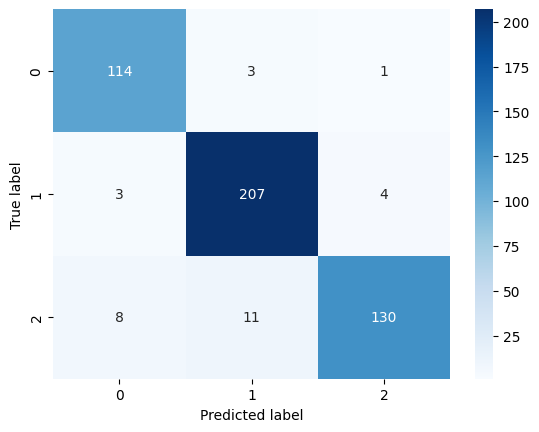

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=2)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=2)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(3, activation='softmax')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)


Epoch 1/10
96/96 [==============================] - 3s 10ms/step - loss: 0.2222 - accuracy: 0.8757
Epoch 2/10
96/96 [==============================] - 1s 9ms/step - loss: 0.1227 - accuracy: 0.9473
Epoch 3/10
96/96 [==============================] - 1s 9ms/step - loss: 0.1177 - accuracy: 0.9531
Epoch 4/10
96/96 [==============================] - 1s 9ms/step - loss: 0.0921 - accuracy: 0.9531
Epoch 5/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0823 - accuracy: 0.9635
Epoch 6/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0729 - accuracy: 0.9681
Epoch 7/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0683 - accuracy: 0.9694
Epoch 8/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0712 - accuracy: 0.9655
Epoch 9/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0537 - accuracy: 0.9727
Epoch 10/10
13/13 [==============================] - 0s 6ms/step - loss: 0.0893 - accuracy: 0.9610
Epoch 1/10
97

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9547077922077921
Precision: 0.955341588429628
Loss: 0.11491381451487541
Recall: 0.9547077922077921
F1-score: 0.9546822166816762


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=3, activation='softmax'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
121/121 [==============================] - 3s 8ms/step - loss: 0.1291 - accuracy: 0.9412 - val_loss: 0.1546 - val_accuracy: 0.9314
Epoch 2/10
121/121 [==============================] - 1s 7ms/step - loss: 0.0878 - accuracy: 0.9584 - val_loss: 0.1458 - val_accuracy: 0.9293
Epoch 3/10
121/121 [==============================] - 1s 5ms/step - loss: 0.0812 - accuracy: 0.9563 - val_loss: 0.1108 - val_accuracy: 0.9480
Epoch 4/10
121/121 [==============================] - 1s 4ms/step - loss: 0.1010 - accuracy: 0.9526 - val_loss: 0.1219 - val_accuracy: 0.9397
Epoch 5/10
121/121 [==============================] - 1s 4ms/step - loss: 0.0649 - accuracy: 0.9672 - val_loss: 0.1054 - val_accuracy: 0.9459
Epoch 6/10
121/121 [==============================] - 0s 4ms/step - loss: 0.0542 - accuracy: 0.9719 - val_loss: 0.1150 - val_accuracy: 0.9501
Epoch 7/10
121/121 [==============================] - 0s 4ms/step - loss: 0.0552 - accuracy: 0.9729 - val_loss: 0.1047 - val_accuracy: 0.9563
Epoch 

In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 0s 2ms/step
Test Accuracy: 0.9501039385795593
Test F1 Score: 0.9492424242424242
Test Recall: 0.9534708925972506
Precision: 0.9457996771774108


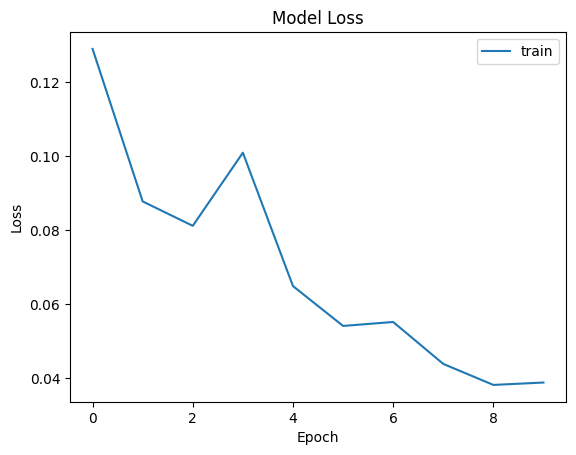

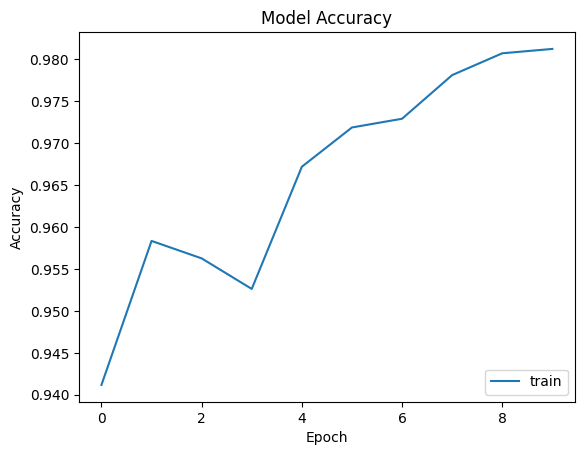

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       118
           1       0.98      0.93      0.96       214
           2       0.92      0.96      0.94       149

    accuracy                           0.95       481
   macro avg       0.95      0.95      0.95       481
weighted avg       0.95      0.95      0.95       481



In [ ]:
plot_history(history4,model4)

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 766, 32)           128       
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 383, 32)          0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 12256)             0         
                                                                 
 dense_60 (Dense)            (None, 64)                784448    
                                                                 
 dense_61 (Dense)            (None, 3)                 195       
                                                                 
Total params: 784,771
Trainable params: 784,771
Non-trainable params: 0
_______________________________________________

16/16 [==============================] - 0s 2ms/step
[[114   1   3]
 [  5 200   9]
 [  3   3 143]]


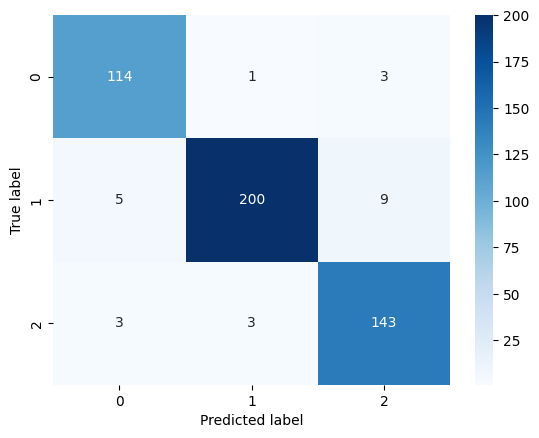

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=3, activation='softmax'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
96/96 [==============================] - 2s 4ms/step - loss: 0.1481 - accuracy: 0.9342
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9512
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0833 - accuracy: 0.9544
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0682 - accuracy: 0.9635
Epoch 5/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0621 - accuracy: 0.9694
Epoch 6/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0584 - accuracy: 0.9707
Epoch 7/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0601 - accuracy: 0.9714
Epoch 8/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0468 - accuracy: 0.9792
Epoch 9/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0462 - accuracy: 0.9772
Epoch 10/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0971 - accuracy: 0.9532
Epoch 1/10
97/97 [=

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.955232683982684
Precision: 0.9555514931488739
Loss: 0.09344541430473327
Recall: 0.955232683982684
F1-score: 0.9552264080759011


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(3, activation='softmax'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
121/121 [==============================] - 9s 17ms/step - loss: 1.3994 - accuracy: 0.9172
Epoch 2/10
121/121 [==============================] - 2s 16ms/step - loss: 0.3368 - accuracy: 0.9521
Epoch 3/10
121/121 [==============================] - 2s 17ms/step - loss: 0.1523 - accuracy: 0.9573
Epoch 4/10
121/121 [==============================] - 3s 21ms/step - loss: 0.1101 - accuracy: 0.9630
Epoch 5/10
121/121 [==============================] - 3s 24ms/step - loss: 0.0969 - accuracy: 0.9636
Epoch 6/10
121/121 [==============================] - 2s 17ms/step - loss: 0.0917 - accuracy: 0.9662
Epoch 7/10
121/121 [==============================] - 2s 17ms/step - loss: 0.0824 - accuracy: 0.9672
Epoch 8/10
121/121 [==============================] - 2s 17ms/step - loss: 0.0750 - accuracy: 0.9708
Epoch 9/10
121/121 [==============================] - 2s 16ms/step - loss: 0.0689 - accuracy: 0.9724
Epoch 10/10
121/121 [==============================] - 2s 16ms/step - loss: 0.0677 - accura

In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels)

y_pred = model5.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 1s 12ms/step
Test Accuracy: 0.9417879581451416
Test F1 Score: 0.9411623759726435
Test Recall: 0.9420796757941693
Precision: 0.9404817404817405


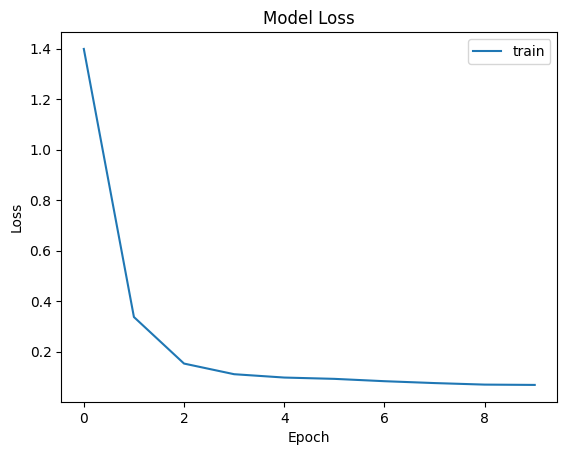

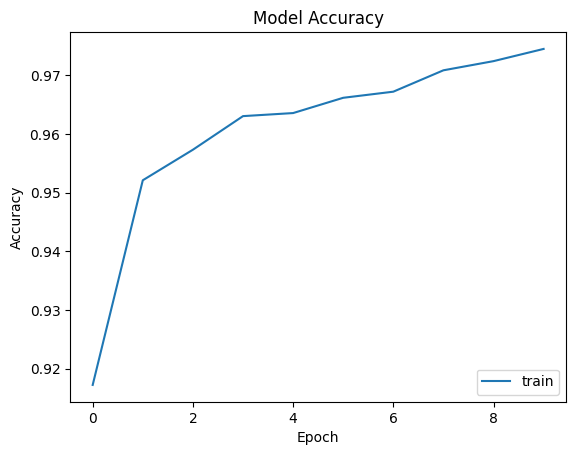

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       118
           1       0.96      0.94      0.95       214
           2       0.92      0.95      0.93       149

    accuracy                           0.94       481
   macro avg       0.94      0.94      0.94       481
weighted avg       0.94      0.94      0.94       481



In [ ]:
plot_history(history5,model5)

In [ ]:
model5.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_60 (MaxPoolin  (None, 382, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_61 (Conv1D)          (None, 378, 128)          82048     
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 189, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirectiona  (None, 189, 128)         98816     
 l)                                                              
                                                     

16/16 [==============================] - 0s 13ms/step
[[111   4   3]
 [  3 201  10]
 [  3   5 141]]


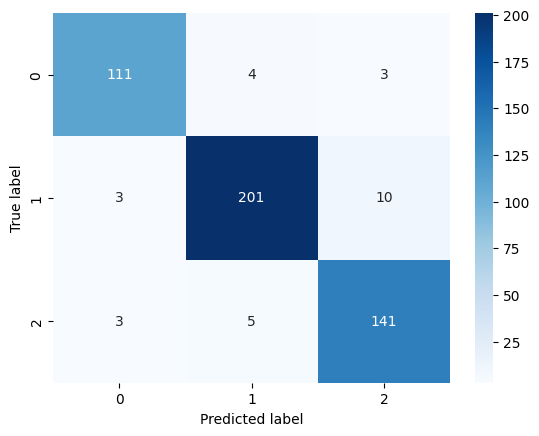

In [ ]:
y_pred = model5.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(3, activation='softmax'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
96/96 [==============================] - 7s 20ms/step - loss: 1.5965 - accuracy: 0.9141
Epoch 2/10
96/96 [==============================] - 2s 20ms/step - loss: 0.4910 - accuracy: 0.9473
Epoch 3/10
96/96 [==============================] - 1s 14ms/step - loss: 0.2182 - accuracy: 0.9518
Epoch 4/10
96/96 [==============================] - 1s 14ms/step - loss: 0.1380 - accuracy: 0.9590
Epoch 5/10
96/96 [==============================] - 1s 14ms/step - loss: 0.1140 - accuracy: 0.9590
Epoch 6/10
96/96 [==============================] - 1s 14ms/step - loss: 0.0948 - accuracy: 0.9629
Epoch 7/10
96/96 [==============================] - 1s 14ms/step - loss: 0.0882 - accuracy: 0.9661
Epoch 8/10
96/96 [==============================] - 1s 15ms/step - loss: 0.0876 - accuracy: 0.9707
Epoch 9/10
96/96 [==============================] - 1s 14ms/step - loss: 0.0734 - accuracy: 0.9727
Epoch 10/10
13/13 [==============================] - 2s 17ms/step - loss: 0.0825 - accuracy: 0.9792
Epoch 1/1

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9604274891774892
Precision: 0.9606174965761693
Loss: 0.10756109207868576
Recall: 0.9604274891774892
F1-score: 0.9603160721172435


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(3, activation='softmax'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
121/121 [==============================] - 3s 7ms/step - loss: 1.5263 - accuracy: 0.4810
Epoch 2/10
121/121 [==============================] - 1s 7ms/step - loss: 0.3562 - accuracy: 0.9068
Epoch 3/10
121/121 [==============================] - 1s 7ms/step - loss: 0.2321 - accuracy: 0.9407
Epoch 4/10
121/121 [==============================] - 1s 8ms/step - loss: 0.1764 - accuracy: 0.9526
Epoch 5/10
121/121 [==============================] - 1s 7ms/step - loss: 0.1600 - accuracy: 0.9594
Epoch 6/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1459 - accuracy: 0.9568
Epoch 7/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1417 - accuracy: 0.9589
Epoch 8/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1318 - accuracy: 0.9620
Epoch 9/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1345 - accuracy: 0.9552
Epoch 10/10
121/121 [==============================] - 1s 5ms/step - loss: 0.1121 - accuracy: 0.9672

In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 0s 2ms/step
Test Accuracy: 0.9480249285697937
Test F1 Score: 0.9488488358630901
Test Recall: 0.9519132601984966
Precision: 0.9465143086906971


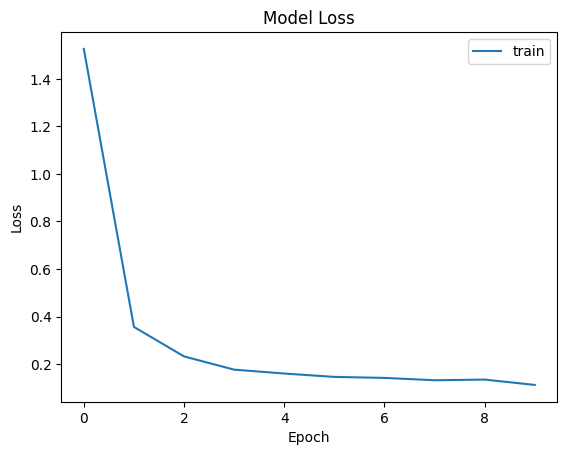

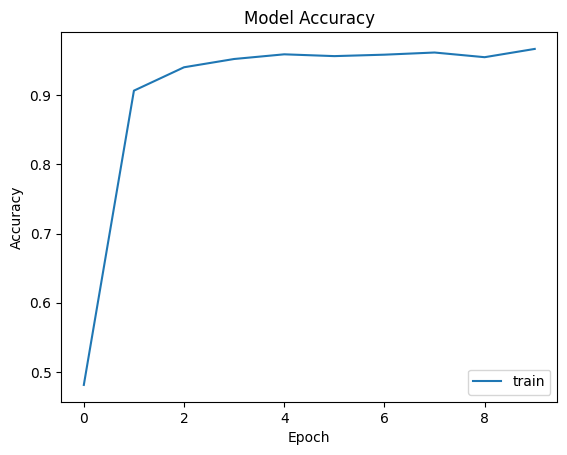

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.97      0.93      0.95       214
           2       0.91      0.96      0.93       149

    accuracy                           0.95       481
   macro avg       0.95      0.95      0.95       481
weighted avg       0.95      0.95      0.95       481



In [ ]:
plot_history(history6,model6)

In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_73 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_74 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_74 (MaxPoolin  (None, 5, 128)         

16/16 [==============================] - 0s 2ms/step
[[114   2   2]
 [  3 199  12]
 [  2   4 143]]


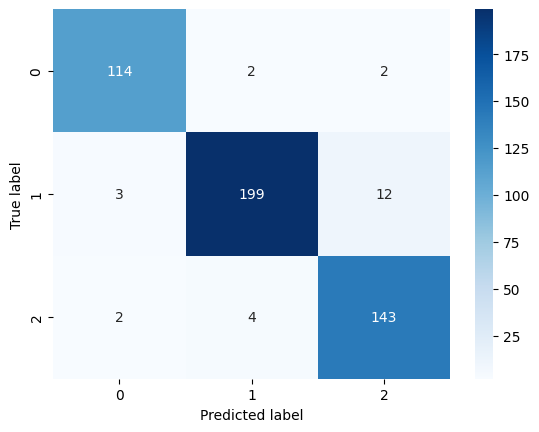

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(3, activation='softmax'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6


kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = []
losses = []
for train_index, test_index in kfold.split(train_embeddings, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.fit(train_embeddings[train_index], train_labels[train_index], epochs=10, batch_size=16, verbose=1)
    y_pred = model.predict(train_embeddings[test_index])
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(train_labels[test_index], axis=1)
    fold_scores = {
        'accuracy': accuracy_score(y_true_labels, y_pred_labels),
        'precision': precision_score(y_true_labels, y_pred_labels, average='weighted'),
        'recall': recall_score(y_true_labels, y_pred_labels, average='weighted'),
        'f1': f1_score(y_true_labels, y_pred_labels, average='weighted')
    }
    results.append(fold_scores)

    loss = model.evaluate(train_embeddings[test_index], train_labels[test_index])
    losses.append(loss[0])

accuracy = np.mean([result['accuracy'] for result in results])
precision = np.mean([result['precision'] for result in results])
recall = np.mean([result['recall'] for result in results])
f1 = np.mean([result['f1'] for result in results])
loss = np.mean(losses)

Epoch 1/10
96/96 [==============================] - 3s 5ms/step - loss: 1.7371 - accuracy: 0.4648
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 0.4703 - accuracy: 0.8626
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.2538 - accuracy: 0.9453
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 0.2055 - accuracy: 0.9473
Epoch 5/10
96/96 [==============================] - 0s 5ms/step - loss: 0.1770 - accuracy: 0.9551
Epoch 6/10
96/96 [==============================] - 0s 5ms/step - loss: 0.1590 - accuracy: 0.9499
Epoch 7/10
96/96 [==============================] - 0s 4ms/step - loss: 0.1481 - accuracy: 0.9564
Epoch 8/10
96/96 [==============================] - 1s 6ms/step - loss: 0.1448 - accuracy: 0.9538
Epoch 9/10
96/96 [==============================] - 1s 6ms/step - loss: 0.1381 - accuracy: 0.9590
Epoch 10/10
13/13 [==============================] - 0s 4ms/step - loss: 0.1227 - accuracy: 0.9584
Epoch 1/10
97/97 [=

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Loss:", loss)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9573133116883117
Precision: 0.9578319229108156
Loss: 0.13749924749135972
Recall: 0.9573133116883117
F1-score: 0.9572560558604618


# Dataset Binary

In [ ]:
path = '/content/drive/MyDrive/PHEME/data.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df = df[df['target'] != 'unverified']

In [ ]:
df.head()

,text,target
0,What we know so far about the major operation ...,true
3,BREAKING: Police official confirms that 12 hav...,true
4,#BREAKING : Both hostages in #Dammartin and #P...,true
5,Update - French interior ministry says inciden...,false
7,This widely shared cartoon about the #CharlieH...,false


In [ ]:
label_encoder = LabelEncoder()
label = df['target']
labels_encoded = label_encoder.fit_transform(label)
df['target'] = labels_encoded
df.head()

<ipython-input-96-8e08a0f8f901>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = labels_encoded


,text,target
0,What we know so far about the major operation ...,1
3,BREAKING: Police official confirms that 12 hav...,1
4,#BREAKING : Both hostages in #Dammartin and #P...,1
5,Update - French interior ministry says inciden...,0
7,This widely shared cartoon about the #CharlieH...,0


## DistilBERT train

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

for layer in model_distil.layers:
    layer.trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_95']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokenizer_distil(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(df['text'].tolist(), tokenizer_distil, max_len=512)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, df['target'].tolist())

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(df['text'].tolist()) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(df['text'].tolist()))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
N_EPOCHS = 3
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/3
682/682 [==============================] - 64s 55ms/step - loss: 0.4303 - accuracy: 0.7969
Epoch 2/3
682/682 [==============================] - 29s 43ms/step - loss: 0.2506 - accuracy: 0.9018
Epoch 3/3
682/682 [==============================] - 29s 43ms/step - loss: 0.1539 - accuracy: 0.9399


In [ ]:
benchmarks = model_distil.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)

171/171 [==============================] - 4s 15ms/step - loss: 0.0530 - accuracy: 0.9883


In [ ]:
print(benchmarks)

{'loss': 0.0530289001762867, 'accuracy': 0.9882698059082031}


In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_95 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


# Statements - Titles

In [ ]:
import nltk
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['text'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]

    batch_embeddings = get_embeddings(batch_titles)

    embeddings.append(batch_embeddings)

100%|██████████| 1705/1705 [03:04<00:00,  9.25it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['target'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/PHEME/embeddings_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/PHEME/labels_bin.npy', labels)

## **CNN-DistilBERT**

In [ ]:
embeddings = np.load('/content/drive/MyDrive/PHEME/embeddings_bin.npy')
labels = np.load('/content/drive/MyDrive/PHEME/labels_bin.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([1364, 768, 1])

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels,epochs=10, batch_size=16)

Epoch 1/10
86/86 [==============================] - 3s 7ms/step - loss: 0.4532 - accuracy: 0.7852
Epoch 2/10
86/86 [==============================] - 0s 5ms/step - loss: 0.1245 - accuracy: 0.9604
Epoch 3/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0935 - accuracy: 0.9751
Epoch 4/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0764 - accuracy: 0.9765
Epoch 5/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0751 - accuracy: 0.9795
Epoch 6/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0668 - accuracy: 0.9846
Epoch 7/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0642 - accuracy: 0.9839
Epoch 8/10
86/86 [==============================] - 1s 6ms/step - loss: 0.0559 - accuracy: 0.9890
Epoch 9/10
86/86 [==============================] - 1s 7ms/step - loss: 0.0348 - accuracy: 0.9890
Epoch 10/10
86/86 [==============================] - 1s 7ms/step - loss: 0.0415 - accuracy: 0.9861


In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

11/11 [==============================] - 0s 3ms/step
Test Accuracy: 0.9853372573852539
Test F1 Score: 0.9886104783599089
Test Recall: 0.9774774774774775
Precision: 1.0


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_90 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_90 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_91 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_91 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_92 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 max_pooling1d_92 (MaxPoolin  (None, 5, 128)         

11/11 [==============================] - 0s 3ms/step
[[119   0]
 [  5 217]]


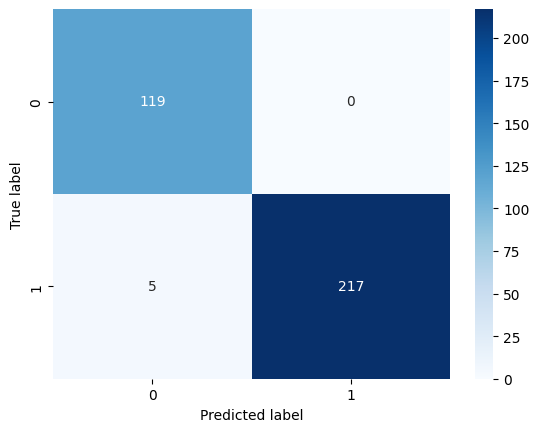

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

    print(classification_report(test_labels, y_pred))

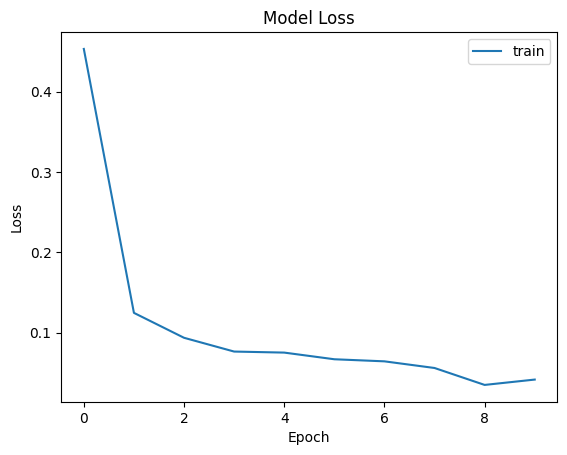

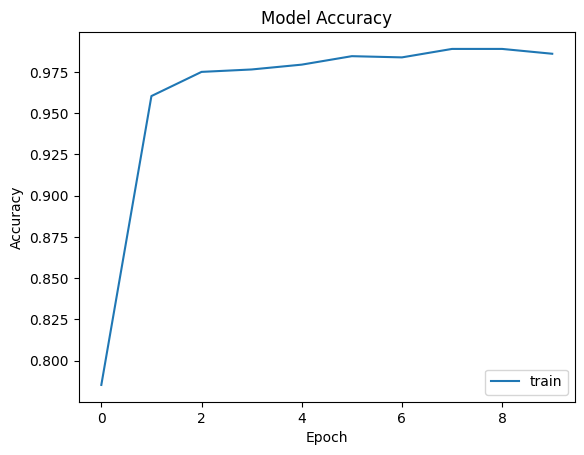

11/11 [==============================] - 0s 3ms/step


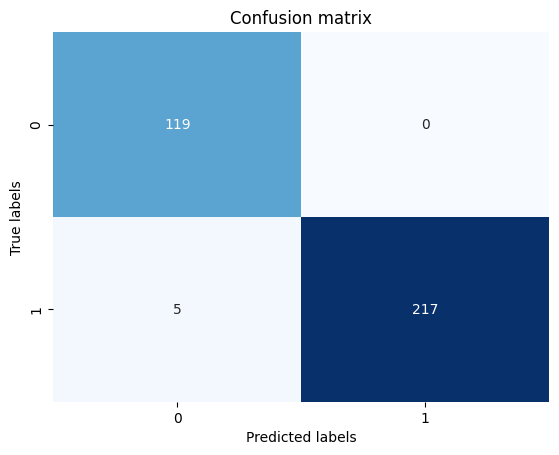

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       119
           1       1.00      0.98      0.99       222

    accuracy                           0.99       341
   macro avg       0.98      0.99      0.98       341
weighted avg       0.99      0.99      0.99       341



In [ ]:
plot_history(history1,model)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
69/69 [==============================] - 3s 8ms/step - loss: 0.5212 - accuracy: 0.7507
Epoch 2/10
69/69 [==============================] - 0s 5ms/step - loss: 0.1399 - accuracy: 0.9578
Epoch 3/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0995 - accuracy: 0.9707
Epoch 4/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0877 - accuracy: 0.9798
Epoch 5/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0784 - accuracy: 0.9743
Epoch 6/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0627 - accuracy: 0.9826
Epoch 7/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0489 - accuracy: 0.9853
Epoch 8/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0508 - accuracy: 0.9881
Epoch 9/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0488 - accuracy: 0.9853
Epoch 10/10
18/18 [==============================] - 0s 3ms/step
Epoch 1/10
69/69 [==============================] - 4

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.98 (+/- 0.02)
Cross-Validation Precision: 0.97 (+/- 0.03)
Cross-Validation Loss: 0.10 (+/- 0.09)
Cross-Validation Recall: 0.99 (+/- 0.01)
Cross-Validation F1 Score: 0.98 (+/- 0.02)


## **LSTM-DistilBERT**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(64, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
86/86 [==============================] - 6s 14ms/step - loss: 0.1349 - accuracy: 0.9487
Epoch 2/10
86/86 [==============================] - 1s 11ms/step - loss: 0.0734 - accuracy: 0.9780
Epoch 3/10
86/86 [==============================] - 1s 11ms/step - loss: 0.0672 - accuracy: 0.9780
Epoch 4/10
86/86 [==============================] - 1s 12ms/step - loss: 0.0636 - accuracy: 0.9765
Epoch 5/10
86/86 [==============================] - 1s 16ms/step - loss: 0.0447 - accuracy: 0.9868
Epoch 6/10
86/86 [==============================] - 1s 16ms/step - loss: 0.0321 - accuracy: 0.9912
Epoch 7/10
86/86 [==============================] - 1s 16ms/step - loss: 0.0357 - accuracy: 0.9883
Epoch 8/10
86/86 [==============================] - 1s 12ms/step - loss: 0.0225 - accuracy: 0.9934
Epoch 9/10
86/86 [==============================] - 1s 11ms/step - loss: 0.0249 - accuracy: 0.9905
Epoch 10/10
86/86 [==============================] - 1s 11ms/step - loss: 0.0269 - accuracy: 0.9912


In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

11/11 - 1s - loss: 0.1023 - accuracy: 0.9707 - 584ms/epoch - 53ms/step
11/11 [==============================] - 1s 7ms/step
Test Accuracy: 0.9706745147705078
Test F1 Score: 0.9770642201834863
Test Recall: 0.9594594594594594
Precision: 0.9953271028037384


In [ ]:
model2.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_108 (Conv1D)         (None, 764, 128)          768       
                                                                 
 max_pooling1d_108 (MaxPooli  (None, 382, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_109 (Conv1D)         (None, 378, 128)          82048     
                                                                 
 max_pooling1d_109 (MaxPooli  (None, 189, 128)         0         
 ng1D)                                                           
                                                                 
 lstm_12 (LSTM)              (None, 189, 64)           49408     
                                                                 
 batch_normalization_12 (Bat  (None, 189, 64)        

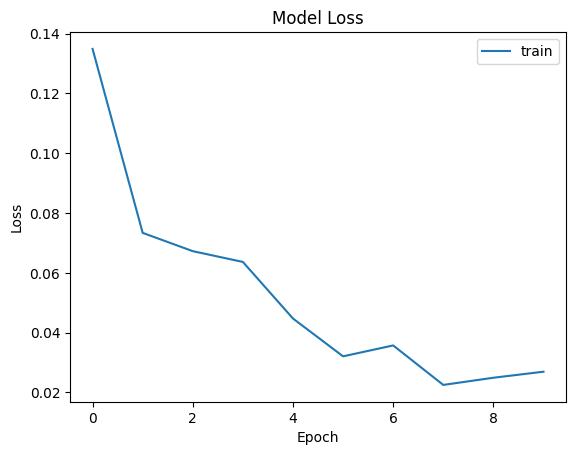

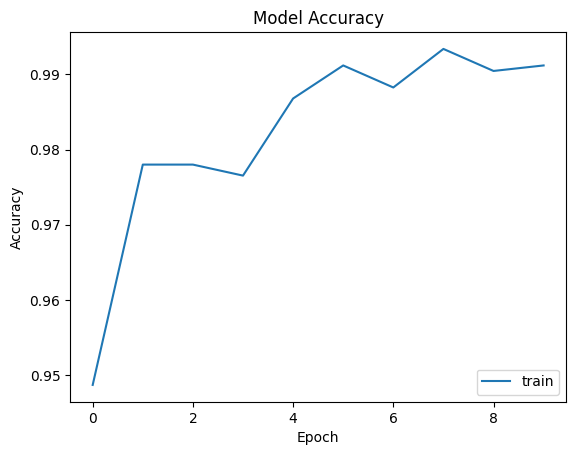

11/11 [==============================] - 0s 9ms/step


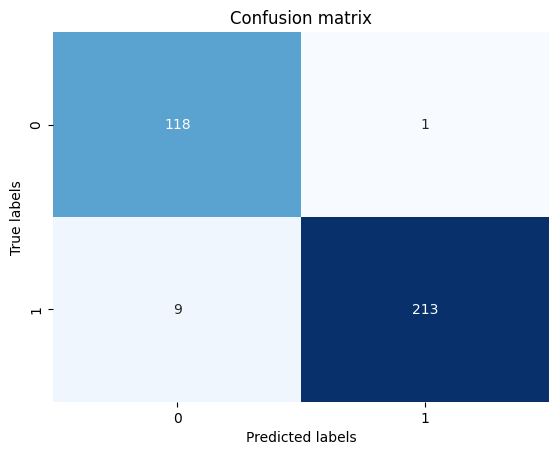

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       119
           1       1.00      0.96      0.98       222

    accuracy                           0.97       341
   macro avg       0.96      0.98      0.97       341
weighted avg       0.97      0.97      0.97       341



In [ ]:
plot_history(history2,model2)

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(Conv1D(128, 5, activation='relu'))
  model2.add(MaxPooling1D(pool_size=2))
  model2.add(LSTM(64, return_sequences=True))
  model2.add(BatchNormalization())
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(32, activation='relu'))
  model2.add(Flatten())
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model2

model2 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model2, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
69/69 [==============================] - 6s 18ms/step - loss: 0.1420 - accuracy: 0.9487
Epoch 2/10
69/69 [==============================] - 1s 16ms/step - loss: 0.0802 - accuracy: 0.9743
Epoch 3/10
69/69 [==============================] - 1s 18ms/step - loss: 0.0736 - accuracy: 0.9753
Epoch 4/10
69/69 [==============================] - 1s 15ms/step - loss: 0.0579 - accuracy: 0.9789
Epoch 5/10
69/69 [==============================] - 1s 11ms/step - loss: 0.0482 - accuracy: 0.9853
Epoch 6/10
69/69 [==============================] - 1s 11ms/step - loss: 0.0465 - accuracy: 0.9863
Epoch 7/10
69/69 [==============================] - 1s 11ms/step - loss: 0.0295 - accuracy: 0.9890
Epoch 8/10
69/69 [==============================] - 1s 11ms/step - loss: 0.0274 - accuracy: 0.9881
Epoch 9/10
69/69 [==============================] - 1s 11ms/step - loss: 0.0309 - accuracy: 0.9908
Epoch 10/10
18/18 [==============================] - 0s 5ms/step
Epoch 1/10
69/69 [==========================

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.98 (+/- 0.02)
Cross-Validation Precision: 0.98 (+/- 0.02)
Cross-Validation Loss: 0.12 (+/- 0.14)
Cross-Validation Recall: 0.98 (+/- 0.05)
Cross-Validation F1 Score: 0.98 (+/- 0.02)


## **FakeBert-DistilBERT**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=5)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=5)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)
model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
86/86 [==============================] - 4s 9ms/step - loss: 0.2080 - accuracy: 0.9113
Epoch 2/10
86/86 [==============================] - 1s 7ms/step - loss: 0.1168 - accuracy: 0.9611
Epoch 3/10
86/86 [==============================] - 1s 7ms/step - loss: 0.0866 - accuracy: 0.9751
Epoch 4/10
86/86 [==============================] - 1s 7ms/step - loss: 0.0754 - accuracy: 0.9751
Epoch 5/10
86/86 [==============================] - 1s 7ms/step - loss: 0.0768 - accuracy: 0.9751
Epoch 6/10
86/86 [==============================] - 1s 7ms/step - loss: 0.0701 - accuracy: 0.9773
Epoch 7/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0605 - accuracy: 0.9809
Epoch 8/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0542 - accuracy: 0.9868
Epoch 9/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0573 - accuracy: 0.9824
Epoch 10/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0456 - accuracy: 0.9875


In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

11/11 - 0s - loss: 0.0592 - accuracy: 0.9883 - 389ms/epoch - 35ms/step
11/11 [==============================] - 0s 4ms/step
Test Accuracy: 0.9882698059082031
Test F1 Score: 0.9909090909090909
Test Recall: 0.9819819819819819
Precision: 1.0


In [ ]:
model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_120 (Conv1D)            (None, 768, 128)     512         ['input_7[0][0]']                
                                                                                                  
 conv1d_121 (Conv1D)            (None, 768, 128)     640         ['input_7[0][0]']                
                                                                                                  
 conv1d_122 (Conv1D)            (None, 768, 128)     768         ['input_7[0][0]']                
                                                                                            

11/11 [==============================] - 0s 4ms/step
[[119   0]
 [  4 218]]


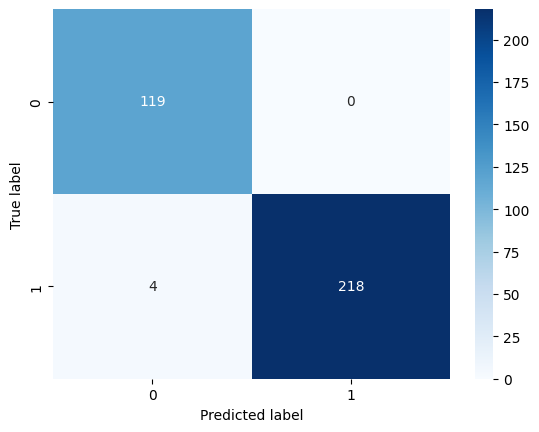

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def create_model():
  inputs = Input(shape=(768, 1))
  conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
  maxpool1 = MaxPooling1D(pool_size=5)(conv1)
  conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
  maxpool2 = MaxPooling1D(pool_size=5)(conv2)
  conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
  maxpool3 = MaxPooling1D(pool_size=5)(conv3)
  concat = Concatenate()([maxpool1, maxpool2, maxpool3])
  conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
  maxpool4 = MaxPooling1D(pool_size=2)(conv4)
  flatten = Flatten()(maxpool4)
  dense1 = Dense(384, activation='relu')(flatten)
  dropout1 = Dropout(0.5)(dense1)
  dense2 = Dense(128, activation='relu')(dropout1)
  dropout2 = Dropout(0.5)(dense2)
  output = Dense(1, activation='sigmoid')(dropout2)
  model3 = Model(inputs=inputs, outputs=output)
  model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model3

model3 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model3, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
69/69 [==============================] - 3s 10ms/step - loss: 0.2744 - accuracy: 0.8900
Epoch 2/10
69/69 [==============================] - 1s 7ms/step - loss: 0.1101 - accuracy: 0.9688
Epoch 3/10
69/69 [==============================] - 1s 7ms/step - loss: 0.0791 - accuracy: 0.9743
Epoch 4/10
69/69 [==============================] - 1s 7ms/step - loss: 0.0755 - accuracy: 0.9780
Epoch 5/10
69/69 [==============================] - 0s 7ms/step - loss: 0.0729 - accuracy: 0.9789
Epoch 6/10
69/69 [==============================] - 0s 7ms/step - loss: 0.0613 - accuracy: 0.9789
Epoch 7/10
69/69 [==============================] - 1s 8ms/step - loss: 0.0628 - accuracy: 0.9789
Epoch 8/10
69/69 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.9798
Epoch 9/10
69/69 [==============================] - 0s 7ms/step - loss: 0.0413 - accuracy: 0.9863
Epoch 10/10
18/18 [==============================] - 0s 3ms/step
Epoch 1/10
69/69 [==============================] - 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.98 (+/- 0.01)
Cross-Validation Precision: 0.98 (+/- 0.02)
Cross-Validation Loss: 0.09 (+/- 0.03)
Cross-Validation Recall: 0.99 (+/- 0.01)
Cross-Validation F1 Score: 0.98 (+/- 0.01)


## **CNN Light - DistilBERT**

In [ ]:
model4 = Sequential()
model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Flatten())
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
86/86 [==============================] - 2s 4ms/step - loss: 0.1187 - accuracy: 0.9575
Epoch 2/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9758
Epoch 3/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.9780
Epoch 4/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0567 - accuracy: 0.9802
Epoch 5/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0464 - accuracy: 0.9853
Epoch 6/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0338 - accuracy: 0.9905
Epoch 7/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0311 - accuracy: 0.9890
Epoch 8/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0264 - accuracy: 0.9897
Epoch 9/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0244 - accuracy: 0.9897
Epoch 10/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0213 - accuracy: 0.9949


In [ ]:
test_loss, test_acc = model4.evaluate(test_embeddings, test_labels)

y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')


f1 = f1_score(test_labels,y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

11/11 [==============================] - 0s 2ms/step
Test Accuracy: 0.9824047088623047
Test F1 Score: 0.9866071428571428
Test Recall: 0.9954954954954955
Precision: 0.9778761061946902


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model4.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_144 (Conv1D)         (None, 766, 32)           128       
                                                                 
 max_pooling1d_144 (MaxPooli  (None, 383, 32)          0         
 ng1D)                                                           
                                                                 
 flatten_54 (Flatten)        (None, 12256)             0         
                                                                 
 dense_174 (Dense)           (None, 64)                784448    
                                                                 
 dense_175 (Dense)           (None, 1)                 65        
                                                                 
Total params: 784,641
Trainable params: 784,641
Non-trainable params: 0
_______________________________________________

11/11 [==============================] - 0s 2ms/step
[[114   5]
 [  1 221]]


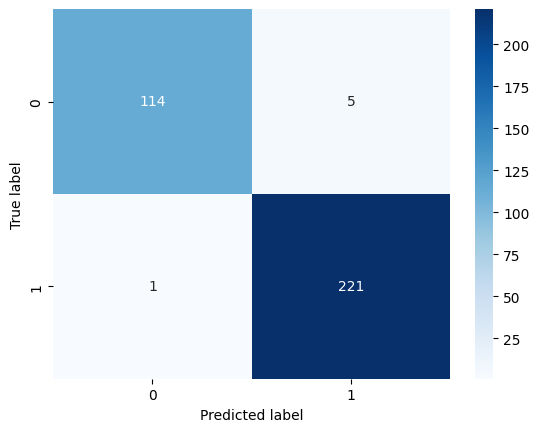

In [ ]:
y_pred = model4.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

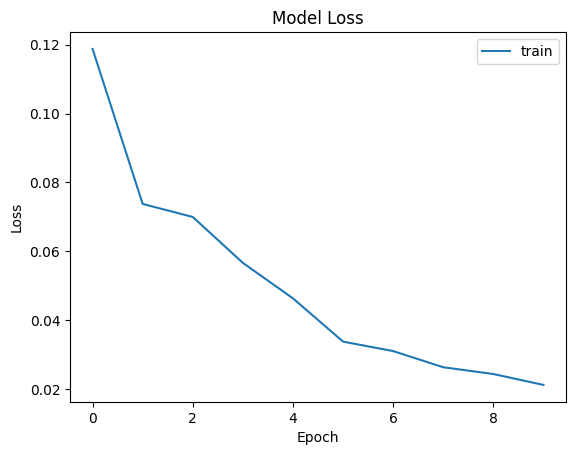

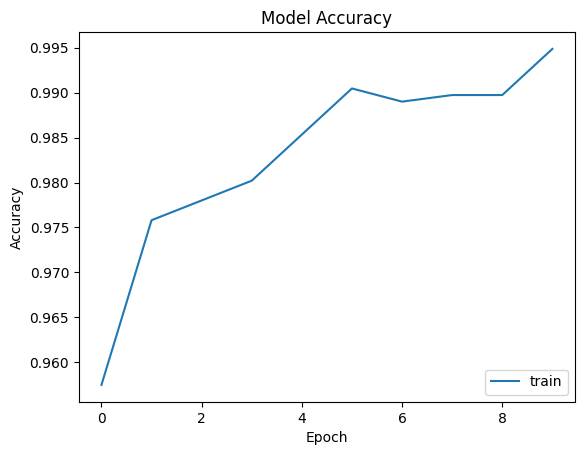

11/11 [==============================] - 0s 2ms/step


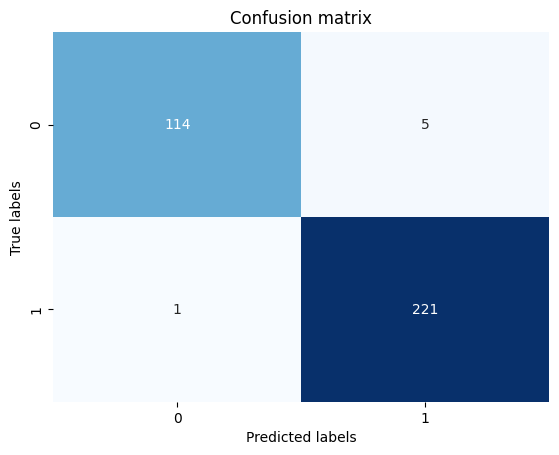

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       119
           1       0.98      1.00      0.99       222

    accuracy                           0.98       341
   macro avg       0.98      0.98      0.98       341
weighted avg       0.98      0.98      0.98       341



In [ ]:
plot_history(history4,model4)

In [ ]:
def create_model():
  model4 = Sequential()
  model4.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
  model4.add(MaxPooling1D(pool_size = 2))
  model4.add(Flatten())
  model4.add(Dense(units=64, activation='relu'))
  model4.add(Dense(units=1, activation='sigmoid'))
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

model4 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model4, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
69/69 [==============================] - 2s 6ms/step - loss: 0.1108 - accuracy: 0.9551
Epoch 2/10
69/69 [==============================] - 1s 8ms/step - loss: 0.0820 - accuracy: 0.9743
Epoch 3/10
69/69 [==============================] - 1s 13ms/step - loss: 0.0639 - accuracy: 0.9762
Epoch 4/10
69/69 [==============================] - 1s 8ms/step - loss: 0.0524 - accuracy: 0.9817
Epoch 5/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0427 - accuracy: 0.9844
Epoch 6/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0325 - accuracy: 0.9908
Epoch 7/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0387 - accuracy: 0.9899
Epoch 8/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0326 - accuracy: 0.9881
Epoch 9/10
69/69 [==============================] - 0s 5ms/step - loss: 0.0260 - accuracy: 0.9936
Epoch 10/10
18/18 [==============================] - 0s 2ms/step
Epoch 1/10
69/69 [==============================] - 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.98 (+/- 0.02)
Cross-Validation Precision: 0.97 (+/- 0.03)
Cross-Validation Loss: 0.08 (+/- 0.07)
Cross-Validation Recall: 0.99 (+/- 0.01)
Cross-Validation F1 Score: 0.98 (+/- 0.02)


## **Bidirectional L2 LSTM-DistilBERT**

In [ ]:
model5 = Sequential()
model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Conv1D(128, 5, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(64, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
86/86 [==============================] - 7s 19ms/step - loss: 1.7339 - accuracy: 0.9604
Epoch 2/10
86/86 [==============================] - 1s 17ms/step - loss: 0.6045 - accuracy: 0.9743
Epoch 3/10
86/86 [==============================] - 2s 21ms/step - loss: 0.2510 - accuracy: 0.9802
Epoch 4/10
86/86 [==============================] - 2s 24ms/step - loss: 0.1470 - accuracy: 0.9773
Epoch 5/10
86/86 [==============================] - 2s 22ms/step - loss: 0.0998 - accuracy: 0.9839
Epoch 6/10
86/86 [==============================] - 1s 17ms/step - loss: 0.0865 - accuracy: 0.9802
Epoch 7/10
86/86 [==============================] - 1s 17ms/step - loss: 0.0632 - accuracy: 0.9883
Epoch 8/10
86/86 [==============================] - 1s 17ms/step - loss: 0.0622 - accuracy: 0.9868
Epoch 9/10
86/86 [==============================] - 1s 17ms/step - loss: 0.0519 - accuracy: 0.9905
Epoch 10/10
86/86 [==============================] - 1s 17ms/step - loss: 0.0497 - accuracy: 0.9868


In [ ]:
test_loss, test_acc = model5.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model5.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

11/11 - 1s - loss: 0.0551 - accuracy: 0.9883 - 1s/epoch - 129ms/step
11/11 [==============================] - 1s 14ms/step
Test Accuracy: 0.9882698059082031
Test F1 Score: 0.9910313901345291
Test Recall: 0.9954954954954955
Precision: 0.9866071428571429


In [ ]:
model5.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_150 (Conv1D)         (None, 764, 128)          768       
                                                                 
 max_pooling1d_150 (MaxPooli  (None, 382, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_151 (Conv1D)         (None, 378, 128)          82048     
                                                                 
 max_pooling1d_151 (MaxPooli  (None, 189, 128)         0         
 ng1D)                                                           
                                                                 
 bidirectional_6 (Bidirectio  (None, 189, 128)         98816     
 nal)                                                            
                                                     

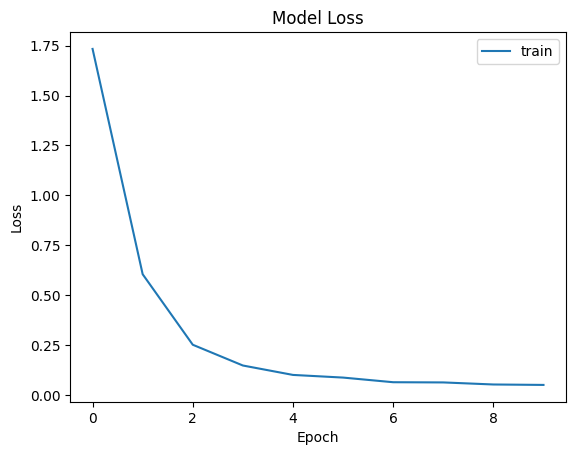

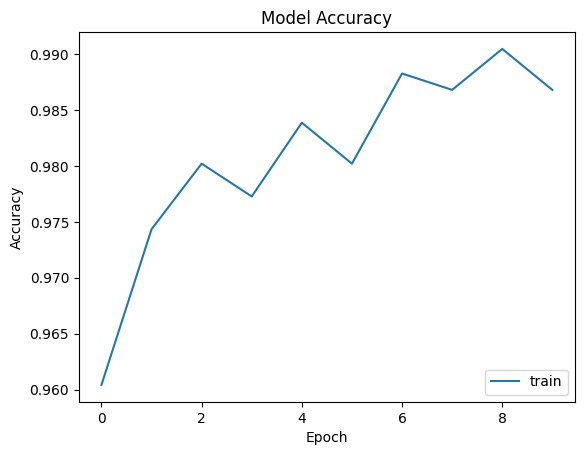

11/11 [==============================] - 0s 14ms/step


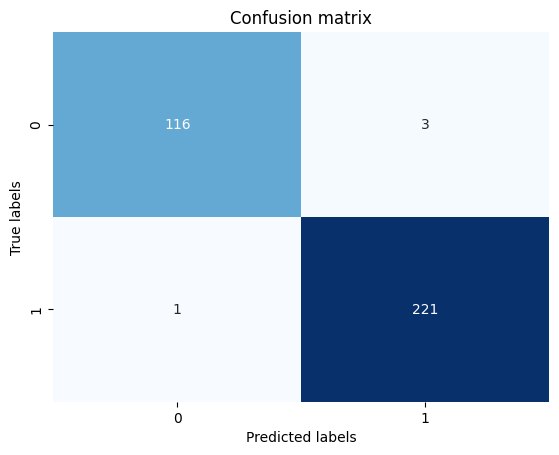

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       119
           1       0.99      1.00      0.99       222

    accuracy                           0.99       341
   macro avg       0.99      0.99      0.99       341
weighted avg       0.99      0.99      0.99       341



In [ ]:
plot_history(history5,model5)

In [ ]:
def create_model():
  model5 = Sequential()
  model5.add(Conv1D(128, 5, activation='relu', input_shape=(768, 1)))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Conv1D(128, 5, activation='relu'))
  model5.add(MaxPooling1D(pool_size=2))
  model5.add(Bidirectional(LSTM(64, return_sequences=True)))
  model5.add(BatchNormalization())
  model5.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model5.add(Flatten())
  model5.add(Dense(1, activation='sigmoid'))
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model5

model5 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model5, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
69/69 [==============================] - 7s 20ms/step - loss: 1.9317 - accuracy: 0.9441
Epoch 2/10
69/69 [==============================] - 1s 17ms/step - loss: 0.8297 - accuracy: 0.9780
Epoch 3/10
69/69 [==============================] - 1s 18ms/step - loss: 0.3761 - accuracy: 0.9771
Epoch 4/10
69/69 [==============================] - 2s 23ms/step - loss: 0.1969 - accuracy: 0.9817
Epoch 5/10
69/69 [==============================] - 2s 26ms/step - loss: 0.1256 - accuracy: 0.9835
Epoch 6/10
69/69 [==============================] - 2s 27ms/step - loss: 0.0838 - accuracy: 0.9872
Epoch 7/10
69/69 [==============================] - 1s 18ms/step - loss: 0.0736 - accuracy: 0.9863
Epoch 8/10
69/69 [==============================] - 1s 19ms/step - loss: 0.0494 - accuracy: 0.9890
Epoch 9/10
69/69 [==============================] - 1s 19ms/step - loss: 0.0426 - accuracy: 0.9936
Epoch 10/10
18/18 [==============================] - 0s 8ms/step
Epoch 1/10
69/69 [==========================

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.97 (+/- 0.01)
Cross-Validation Precision: 0.99 (+/- 0.02)
Cross-Validation Loss: 0.11 (+/- 0.07)
Cross-Validation Recall: 0.96 (+/- 0.04)
Cross-Validation F1 Score: 0.97 (+/- 0.01)


## **L2 CNN-DistilBERT**

In [ ]:
# build the model
model6 = Sequential()
model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Conv1D(128, 5, activation='relu'))
model6.add(MaxPooling1D(pool_size=5))
model6.add(Flatten())
model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model6.add(Dropout(0.5))
model6.add(Dense(1, activation='sigmoid'))

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_embeddings, train_labels, epochs=10, batch_size=16)

Epoch 1/10
86/86 [==============================] - 4s 9ms/step - loss: 1.7372 - accuracy: 0.7617
Epoch 2/10
86/86 [==============================] - 1s 9ms/step - loss: 0.4117 - accuracy: 0.9648
Epoch 3/10
86/86 [==============================] - 1s 9ms/step - loss: 0.2470 - accuracy: 0.9699
Epoch 4/10
86/86 [==============================] - 1s 6ms/step - loss: 0.1841 - accuracy: 0.9758
Epoch 5/10
86/86 [==============================] - 0s 6ms/step - loss: 0.1608 - accuracy: 0.9765
Epoch 6/10
86/86 [==============================] - 1s 6ms/step - loss: 0.1266 - accuracy: 0.9839
Epoch 7/10
86/86 [==============================] - 1s 6ms/step - loss: 0.1068 - accuracy: 0.9831
Epoch 8/10
86/86 [==============================] - 1s 6ms/step - loss: 0.1086 - accuracy: 0.9787
Epoch 9/10
86/86 [==============================] - 0s 5ms/step - loss: 0.1008 - accuracy: 0.9831
Epoch 10/10
86/86 [==============================] - 0s 6ms/step - loss: 0.0823 - accuracy: 0.9846


In [ ]:
test_loss, test_acc = model6.evaluate(test_embeddings, test_labels)

y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

11/11 [==============================] - 0s 2ms/step
Test Accuracy: 0.9824047088623047
Test F1 Score: 0.9865470852017937
Test Recall: 0.990990990990991
Precision: 0.9821428571428571


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model6.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_162 (Conv1D)         (None, 764, 128)          768       
                                                                 
 max_pooling1d_162 (MaxPooli  (None, 152, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_163 (Conv1D)         (None, 148, 128)          82048     
                                                                 
 max_pooling1d_163 (MaxPooli  (None, 29, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_164 (Conv1D)         (None, 25, 128)           82048     
                                                                 
 max_pooling1d_164 (MaxPooli  (None, 5, 128)         

11/11 [==============================] - 0s 2ms/step
[[115   4]
 [  2 220]]


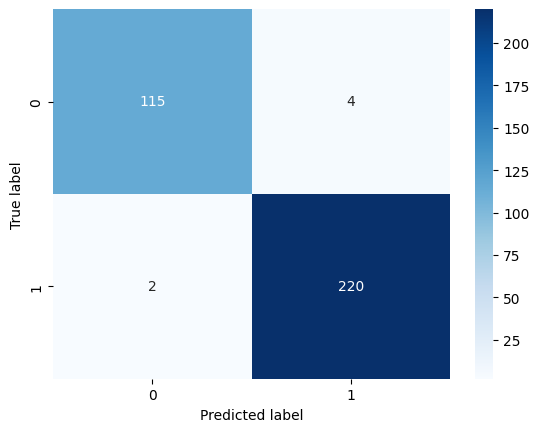

In [ ]:
y_pred = model6.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

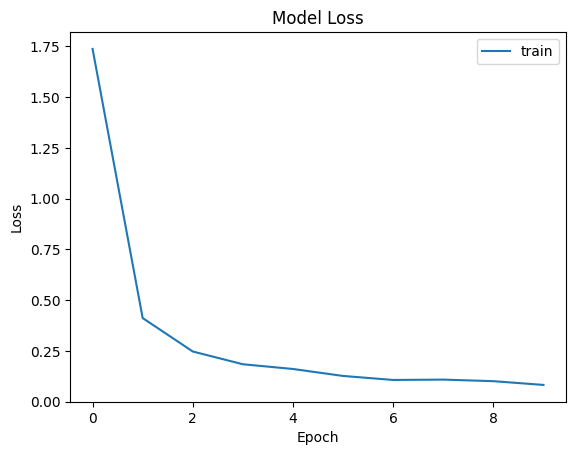

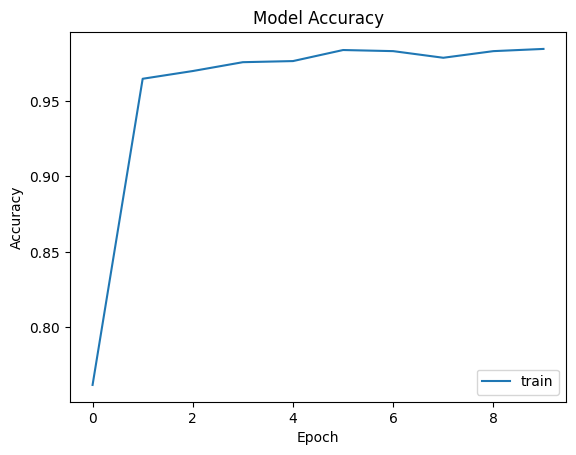

11/11 [==============================] - 0s 2ms/step


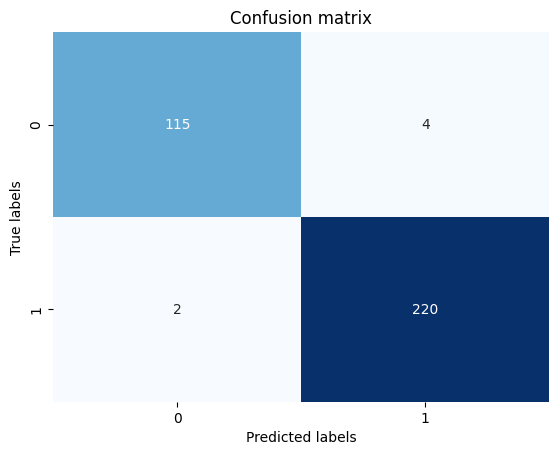

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       119
           1       0.98      0.99      0.99       222

    accuracy                           0.98       341
   macro avg       0.98      0.98      0.98       341
weighted avg       0.98      0.98      0.98       341



In [ ]:
plot_history(history6,model6)

In [ ]:
def create_model():
  model6 = Sequential()
  model6.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Conv1D(128, 5, activation='relu'))
  model6.add(MaxPooling1D(pool_size=5))
  model6.add(Flatten())
  model6.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model6.add(Dropout(0.5))
  model6.add(Dense(1, activation='sigmoid'))
  model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model6

model6 = KerasClassifier(model=create_model, epochs=10, batch_size=16)

kfold = StratifiedKFold(n_splits=5, shuffle=True)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'loss': 'neg_log_loss',
    'recall': 'recall',
    'f1': 'f1',
}

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

results = cross_validate(model6, train_embeddings, train_labels, cv=kfold, scoring=scoring)

Epoch 1/10
69/69 [==============================] - 4s 7ms/step - loss: 1.9875 - accuracy: 0.7250
Epoch 2/10
69/69 [==============================] - 0s 7ms/step - loss: 0.5161 - accuracy: 0.9588
Epoch 3/10
69/69 [==============================] - 1s 8ms/step - loss: 0.2965 - accuracy: 0.9743
Epoch 4/10
69/69 [==============================] - 1s 8ms/step - loss: 0.2034 - accuracy: 0.9762
Epoch 5/10
69/69 [==============================] - 1s 8ms/step - loss: 0.1736 - accuracy: 0.9762
Epoch 6/10
69/69 [==============================] - 1s 7ms/step - loss: 0.1342 - accuracy: 0.9771
Epoch 7/10
69/69 [==============================] - 1s 8ms/step - loss: 0.1296 - accuracy: 0.9798
Epoch 8/10
69/69 [==============================] - 1s 8ms/step - loss: 0.1349 - accuracy: 0.9780
Epoch 9/10
69/69 [==============================] - 1s 10ms/step - loss: 0.0941 - accuracy: 0.9853
Epoch 10/10
18/18 [==============================] - 0s 2ms/step
Epoch 1/10
69/69 [==============================] - 

In [ ]:
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (results['test_accuracy'].mean(), results['test_accuracy'].std() * 2))
print("Cross-Validation Precision: %0.2f (+/- %0.2f)" % (results['test_precision'].mean(), results['test_precision'].std() * 2))
print("Cross-Validation Loss: %0.2f (+/- %0.2f)" % (-results['test_loss'].mean(), results['test_loss'].std() * 2))
print("Cross-Validation Recall: %0.2f (+/- %0.2f)" % (results['test_recall'].mean(), results['test_recall'].std() * 2))
print("Cross-Validation F1 Score: %0.2f (+/- %0.2f)" % (results['test_f1'].mean(), results['test_f1'].std() * 2))

Cross-Validation Accuracy: 0.98 (+/- 0.02)
Cross-Validation Precision: 0.98 (+/- 0.02)
Cross-Validation Loss: 0.08 (+/- 0.05)
Cross-Validation Recall: 0.98 (+/- 0.03)
Cross-Validation F1 Score: 0.98 (+/- 0.01)
